In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy


In [2]:
mf6exe = 'mf6beta'

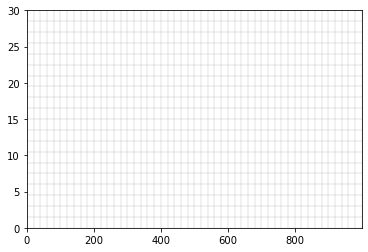

In [3]:
def make_grid(nlay, nrow, ncol, lx, top0):
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)

    delr = lx / ncol
    delc = 1.
    delv = top0 / nlay
    top[:, :] = top0
    
    for k in range(nlay):
        tp = top0
        if k > 0:
            tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    return (delr, delc, top, botm)

nlay = 20
nrow = 1
ncol = 50
lx = 1000.
top0 = 30.
delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)
mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                         delr=delr, delc=delc, top=top, botm=botm)
pxs = flopy.plot.PlotCrossSection(modelgrid=mg, line={'row': 0})
pxs.plot_grid(alpha=1., lw=0.1)

In [4]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

def get_sealevel(t, sl_start, slr_rate):
    return sl_start + slr_rate * t

def get_top(x, top0, slopels):
    return top0 + x * slopels

In [5]:
def get_model(ws, name, nlay, nrow, ncol, lx,
              top0, sl_start, slr_rate, time_end,
              hydraulic_conductivity, specific_storage, porosity, 
              recharge,
              alpha_l, alpha_t,
              cfresh, csalt,
              nper=100,
              hstrt=None, cstrt=None,
              converge_continue=False,
              constant_concentration=False,
              etrate=0., etsurface=None, etdepth=None, 
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)

    nstp = 1
    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if hstrt is None:
        hstrt = sl_start
    else:
        hstrt = {'filename': 'hstrt.bin', 'factor': 1.0, 
                 'data': hstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=1,
                                  k=hydraulic_conductivity)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    hhformulation = True
    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)

    # ghb on left edge
    delt = time_end / nper
    delv = top[0, 0] - botm[0, 0, 0]
    ghbdict = {}
    cond = hydraulic_conductivity * delc * delv / (0.5 * delr[0])
    for iper, t in enumerate(np.arange(delt, time_end + delt, delt)):
        sl = get_sealevel(t, sl_start, slr_rate)
        ghblist = []
        for k in range(nlay):
            if sl > botm[k, 0, 0]:
                tp = top[0, 0]
                if k > 1:
                    tp = botm[k - 1, 0, 0]
                delv = tp - botm[k, 0, 0]
                satdz = min(tp, sl) - botm[k, 0, 0]
                cond = hydraulic_conductivity * delc[0] * satdz / (0.5 * delr[0])
                elev = botm[k, 0, 0] + 0.5 * satdz
                ghblist.append([(k, 0, 0), sl, cond, csalt, calcdens(csalt), elev])
        if len(ghblist) > 0:
            ghbdict[iper] = ghblist
    if len(ghbdict) > 0:
        ghb = flopy.mf6.ModflowGwfghb(gwf,
                                      stress_period_data=ghbdict,
                                      print_input=True,
                                      print_flows=True,
                                      save_flows=False,
                                      auxiliary=['CONCENTRATION', 'DENSITY', 'ELEVATION'],
                                      pname='GHB-LEFT',
                                      filename='{}.left.ghb'.format(gwfname))
        
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    
    if etsurface is None:
        etsurface = top0
    if etdepth is not None:
        evt = flopy.mf6.ModflowGwfevta(gwf, surface=etsurface, rate=etrate, depth=etdepth)
    
    # output control
    saverecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {'filename': 'cstrt.bin', 'factor': 1.0, 
                 'data': cstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=0.,
                                  alh=alpha_l, ath1=alpha_t)

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

    # sources
    sourcerecarray = [('GHB-LEFT', 'AUX', 'CONCENTRATION'),
                     ]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    # constant concentration
    if constant_concentration:
        cnclist = []
        for k in range(1, nlay):
            cnclist.append([(k, 0, 0), 35.])
        cnc1 = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cnclist)
        
        if len(cncdict) > 0:
            cnc2 = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cncdict,
                                           pname='CNC-2',
                                           filename='{}2.cnc'.format(gwtname))

    # output control
    saverecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'ALL')],
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [6]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    return head, conc, spdis, times

In [7]:
def lens_analytical(x, t, length, porosity, hydraulic_conductivity, recharge, rhof, rhos):
    alpha = rhof / (rhos - rhof)
    pl = np.sqrt(recharge / hydraulic_conductivity / (1 + alpha))
    taul = np.pi * porosity * length / 4. * np.sqrt((1 + alpha) / hydraulic_conductivity / recharge)
    fl = np.tanh(t / taul)
    h = fl * pl * np.sqrt(np.square(length) - np.square(x))
    d = alpha * h
    return x, np.flipud(h), np.flipud(d)

In [8]:
def lens_volume(gwf, head, conc, csalt=35.):
    nlay, nrow, ncol = head.shape
    top = gwf.dis.top.array
    botm = gwf.dis.botm.array
    delr = gwf.dis.delr.array
    delc = gwf.dis.delc.array
    fresh_volume = 0.
    for k in range(nlay):
        for i in range(nrow):
            for j in range(ncol):
                tp = top[i, j]
                if k > 0:
                    tp = botm[k - 1, i, j]
                hd = max(head[k, i, j], botm[k, i, j])
                sat_thick = min(tp, hd) - botm[k, i, j]
                sat_vol = sat_thick * delr[j] * delc[i]
                fvol = sat_vol * (1. - conc[k, i, j] / csalt)
                fresh_volume += fvol
    return fresh_volume

def lens_volume_timeseries(gwf, head, conc, times):
    nper = conc.shape[0]
    results = np.empty((nper, 2))
    kperlist = range(0, nper)
    for i, kper in enumerate(kperlist):
        results[kper, 0] = times[kper]
        results[kper, 1] = lens_volume(gwf, head[kper], conc[kper])
    return results

In [9]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

In [10]:
def make_figure(gwf, head, conc, spdis, sl, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_aspect('auto')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    # analytical solution, if specified
    if asoln is not None:
        x, h, z = asoln
        ax.plot(x, sl - z, 'w--')

    # 50% seawater line
    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.array([.5])* csalt, 
                      linestyles = ['-'], colors=['k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.zcellcenters
        X, Y = np.meshgrid(x, y[:, 0, 0])
        u = spdis['qx']
        u = u.reshape(X.shape)
        v = spdis['qz']
        v = v.reshape(X.shape)
        sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)

    #xsl = (sl - top0) / slopels
    #sea_poly = [[0, sl], [xsl, sl], [0, top0], [0, sl]]
    #sea_patch = matplotlib.patches.Polygon(sea_poly, closed=True, edgecolor='k', facecolor='red')
    #ax.add_patch(sea_patch)        

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
    
    if ax2dict is not None:
        with plt.rc_context({'axes.edgecolor':'white', 
                             'axes.facecolor':'yellow',
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'font.size': 8,
                             'axes.labelcolor': 'white',
                             }):
            if 'limits' in ax2dict:
                limits = ax2dict['limits']
            else:
                limits = [0.15, 0.22, 0.2, 0.2]
            xdata = ax2dict['xdata']
            ydata = ax2dict['ydata']
            ax2 = fig.add_axes(limits)
            ax2.plot(xdata, ydata, 'k-')
            if 'xlim' in ax2dict:
                ax2.set_xlim(*ax2dict['xlim'])
            if 'ylim' in ax2dict:
                ax2.set_ylim(*ax2dict['ylim'])
            if 'xlabel' in ax2dict:
                ax2.set_xlabel(ax2dict['xlabel'])
            if 'ylabel' in ax2dict:
                ax2.set_ylabel(ax2dict['ylabel'])
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [11]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# No SLR

In [12]:
gfact = 0.5
nlay = int(85 * gfact)
nrow = 1
ncol = int(100 * gfact)
lx = 1000.
top0 = 85.
nper = 2000
sl_start = 80.
slr_rate = 0.
time_end = 365. * 2000
cfresh = 0.
csalt = 35.
recharge = 18.25 / 1000. / 365. # convert mm/yr to m/yr to m/day
porosity = 0.20
hydraulic_conductivity = 1. # m/day
specific_storage = 0.008 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter

In [13]:
ws0 = 'temp/pxx_gwt_slr-island0'
name = 'slr'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx,
                 top0, sl_start, slr_rate, time_end, 
                 hydraulic_conductivity, specific_storage, porosity, 
                 recharge,
                 alpha_l, alpha_t,
                 cfresh, csalt,
                 constant_concentration=False,
                 verbosity_level=1, nper=nper)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package slr.gwfgwt...
  writing model gwf_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-left...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 40 based on size of stress_period_data
    writing package rcha...
    writing package oc...
  writing model gwt_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6beta
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULA

 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   129    Time step:     1
 Solving:  Stress period:   130    Time step:     1
 Solving:  Stress period:   131    Time step:     1
 Solving:  Stress period:   132    Time step:     1
 Solving:  Stress period:   133    Time step:     1
 Solving:  Stress period:   134    Time step:     1
 Solving:  Stress period:   135    Time step:     1
 Solving:  Stress period:   136    Time step:     1
 Solving:  Stress period:   137    Time step:     1
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   139    Time step:     1
 Solving:  Stress period:   140    Time step:     1
 Solving:  Stress period:   141    Time step:     1
 Solving:  Stress period:   142    Time step:     1
 Solving:  Stress period:   143    Time step:     1
 Solving:  Stress period:   144    Time step:     1
 Solving:  Stress period:   145    Time step:     1
 Solving:  Stress period:   146    Time step:     1
 Solving:  S

 Solving:  Stress period:   295    Time step:     1
 Solving:  Stress period:   296    Time step:     1
 Solving:  Stress period:   297    Time step:     1
 Solving:  Stress period:   298    Time step:     1
 Solving:  Stress period:   299    Time step:     1
 Solving:  Stress period:   300    Time step:     1
 Solving:  Stress period:   301    Time step:     1
 Solving:  Stress period:   302    Time step:     1
 Solving:  Stress period:   303    Time step:     1
 Solving:  Stress period:   304    Time step:     1
 Solving:  Stress period:   305    Time step:     1
 Solving:  Stress period:   306    Time step:     1
 Solving:  Stress period:   307    Time step:     1
 Solving:  Stress period:   308    Time step:     1
 Solving:  Stress period:   309    Time step:     1
 Solving:  Stress period:   310    Time step:     1
 Solving:  Stress period:   311    Time step:     1
 Solving:  Stress period:   312    Time step:     1
 Solving:  Stress period:   313    Time step:     1
 Solving:  S

 Solving:  Stress period:   458    Time step:     1
 Solving:  Stress period:   459    Time step:     1
 Solving:  Stress period:   460    Time step:     1
 Solving:  Stress period:   461    Time step:     1
 Solving:  Stress period:   462    Time step:     1
 Solving:  Stress period:   463    Time step:     1
 Solving:  Stress period:   464    Time step:     1
 Solving:  Stress period:   465    Time step:     1
 Solving:  Stress period:   466    Time step:     1
 Solving:  Stress period:   467    Time step:     1
 Solving:  Stress period:   468    Time step:     1
 Solving:  Stress period:   469    Time step:     1
 Solving:  Stress period:   470    Time step:     1
 Solving:  Stress period:   471    Time step:     1
 Solving:  Stress period:   472    Time step:     1
 Solving:  Stress period:   473    Time step:     1
 Solving:  Stress period:   474    Time step:     1
 Solving:  Stress period:   475    Time step:     1
 Solving:  Stress period:   476    Time step:     1
 Solving:  S

 Solving:  Stress period:   625    Time step:     1
 Solving:  Stress period:   626    Time step:     1
 Solving:  Stress period:   627    Time step:     1
 Solving:  Stress period:   628    Time step:     1
 Solving:  Stress period:   629    Time step:     1
 Solving:  Stress period:   630    Time step:     1
 Solving:  Stress period:   631    Time step:     1
 Solving:  Stress period:   632    Time step:     1
 Solving:  Stress period:   633    Time step:     1
 Solving:  Stress period:   634    Time step:     1
 Solving:  Stress period:   635    Time step:     1
 Solving:  Stress period:   636    Time step:     1
 Solving:  Stress period:   637    Time step:     1
 Solving:  Stress period:   638    Time step:     1
 Solving:  Stress period:   639    Time step:     1
 Solving:  Stress period:   640    Time step:     1
 Solving:  Stress period:   641    Time step:     1
 Solving:  Stress period:   642    Time step:     1
 Solving:  Stress period:   643    Time step:     1
 Solving:  S

 Solving:  Stress period:   787    Time step:     1
 Solving:  Stress period:   788    Time step:     1
 Solving:  Stress period:   789    Time step:     1
 Solving:  Stress period:   790    Time step:     1
 Solving:  Stress period:   791    Time step:     1
 Solving:  Stress period:   792    Time step:     1
 Solving:  Stress period:   793    Time step:     1
 Solving:  Stress period:   794    Time step:     1
 Solving:  Stress period:   795    Time step:     1
 Solving:  Stress period:   796    Time step:     1
 Solving:  Stress period:   797    Time step:     1
 Solving:  Stress period:   798    Time step:     1
 Solving:  Stress period:   799    Time step:     1
 Solving:  Stress period:   800    Time step:     1
 Solving:  Stress period:   801    Time step:     1
 Solving:  Stress period:   802    Time step:     1
 Solving:  Stress period:   803    Time step:     1
 Solving:  Stress period:   804    Time step:     1
 Solving:  Stress period:   805    Time step:     1
 Solving:  S

 Solving:  Stress period:   947    Time step:     1
 Solving:  Stress period:   948    Time step:     1
 Solving:  Stress period:   949    Time step:     1
 Solving:  Stress period:   950    Time step:     1
 Solving:  Stress period:   951    Time step:     1
 Solving:  Stress period:   952    Time step:     1
 Solving:  Stress period:   953    Time step:     1
 Solving:  Stress period:   954    Time step:     1
 Solving:  Stress period:   955    Time step:     1
 Solving:  Stress period:   956    Time step:     1
 Solving:  Stress period:   957    Time step:     1
 Solving:  Stress period:   958    Time step:     1
 Solving:  Stress period:   959    Time step:     1
 Solving:  Stress period:   960    Time step:     1
 Solving:  Stress period:   961    Time step:     1
 Solving:  Stress period:   962    Time step:     1
 Solving:  Stress period:   963    Time step:     1
 Solving:  Stress period:   964    Time step:     1
 Solving:  Stress period:   965    Time step:     1
 Solving:  S

 Solving:  Stress period:  1111    Time step:     1
 Solving:  Stress period:  1112    Time step:     1
 Solving:  Stress period:  1113    Time step:     1
 Solving:  Stress period:  1114    Time step:     1
 Solving:  Stress period:  1115    Time step:     1
 Solving:  Stress period:  1116    Time step:     1
 Solving:  Stress period:  1117    Time step:     1
 Solving:  Stress period:  1118    Time step:     1
 Solving:  Stress period:  1119    Time step:     1
 Solving:  Stress period:  1120    Time step:     1
 Solving:  Stress period:  1121    Time step:     1
 Solving:  Stress period:  1122    Time step:     1
 Solving:  Stress period:  1123    Time step:     1
 Solving:  Stress period:  1124    Time step:     1
 Solving:  Stress period:  1125    Time step:     1
 Solving:  Stress period:  1126    Time step:     1
 Solving:  Stress period:  1127    Time step:     1
 Solving:  Stress period:  1128    Time step:     1
 Solving:  Stress period:  1129    Time step:     1
 Solving:  S

 Solving:  Stress period:  1275    Time step:     1
 Solving:  Stress period:  1276    Time step:     1
 Solving:  Stress period:  1277    Time step:     1
 Solving:  Stress period:  1278    Time step:     1
 Solving:  Stress period:  1279    Time step:     1
 Solving:  Stress period:  1280    Time step:     1
 Solving:  Stress period:  1281    Time step:     1
 Solving:  Stress period:  1282    Time step:     1
 Solving:  Stress period:  1283    Time step:     1
 Solving:  Stress period:  1284    Time step:     1
 Solving:  Stress period:  1285    Time step:     1
 Solving:  Stress period:  1286    Time step:     1
 Solving:  Stress period:  1287    Time step:     1
 Solving:  Stress period:  1288    Time step:     1
 Solving:  Stress period:  1289    Time step:     1
 Solving:  Stress period:  1290    Time step:     1
 Solving:  Stress period:  1291    Time step:     1
 Solving:  Stress period:  1292    Time step:     1
 Solving:  Stress period:  1293    Time step:     1
 Solving:  S

 Solving:  Stress period:  1435    Time step:     1
 Solving:  Stress period:  1436    Time step:     1
 Solving:  Stress period:  1437    Time step:     1
 Solving:  Stress period:  1438    Time step:     1
 Solving:  Stress period:  1439    Time step:     1
 Solving:  Stress period:  1440    Time step:     1
 Solving:  Stress period:  1441    Time step:     1
 Solving:  Stress period:  1442    Time step:     1
 Solving:  Stress period:  1443    Time step:     1
 Solving:  Stress period:  1444    Time step:     1
 Solving:  Stress period:  1445    Time step:     1
 Solving:  Stress period:  1446    Time step:     1
 Solving:  Stress period:  1447    Time step:     1
 Solving:  Stress period:  1448    Time step:     1
 Solving:  Stress period:  1449    Time step:     1
 Solving:  Stress period:  1450    Time step:     1
 Solving:  Stress period:  1451    Time step:     1
 Solving:  Stress period:  1452    Time step:     1
 Solving:  Stress period:  1453    Time step:     1
 Solving:  S

 Solving:  Stress period:  1595    Time step:     1
 Solving:  Stress period:  1596    Time step:     1
 Solving:  Stress period:  1597    Time step:     1
 Solving:  Stress period:  1598    Time step:     1
 Solving:  Stress period:  1599    Time step:     1
 Solving:  Stress period:  1600    Time step:     1
 Solving:  Stress period:  1601    Time step:     1
 Solving:  Stress period:  1602    Time step:     1
 Solving:  Stress period:  1603    Time step:     1
 Solving:  Stress period:  1604    Time step:     1
 Solving:  Stress period:  1605    Time step:     1
 Solving:  Stress period:  1606    Time step:     1
 Solving:  Stress period:  1607    Time step:     1
 Solving:  Stress period:  1608    Time step:     1
 Solving:  Stress period:  1609    Time step:     1
 Solving:  Stress period:  1610    Time step:     1
 Solving:  Stress period:  1611    Time step:     1
 Solving:  Stress period:  1612    Time step:     1
 Solving:  Stress period:  1613    Time step:     1
 Solving:  S

 Solving:  Stress period:  1756    Time step:     1
 Solving:  Stress period:  1757    Time step:     1
 Solving:  Stress period:  1758    Time step:     1
 Solving:  Stress period:  1759    Time step:     1
 Solving:  Stress period:  1760    Time step:     1
 Solving:  Stress period:  1761    Time step:     1
 Solving:  Stress period:  1762    Time step:     1
 Solving:  Stress period:  1763    Time step:     1
 Solving:  Stress period:  1764    Time step:     1
 Solving:  Stress period:  1765    Time step:     1
 Solving:  Stress period:  1766    Time step:     1
 Solving:  Stress period:  1767    Time step:     1
 Solving:  Stress period:  1768    Time step:     1
 Solving:  Stress period:  1769    Time step:     1
 Solving:  Stress period:  1770    Time step:     1
 Solving:  Stress period:  1771    Time step:     1
 Solving:  Stress period:  1772    Time step:     1
 Solving:  Stress period:  1773    Time step:     1
 Solving:  Stress period:  1774    Time step:     1
 Solving:  S

 Solving:  Stress period:  1920    Time step:     1
 Solving:  Stress period:  1921    Time step:     1
 Solving:  Stress period:  1922    Time step:     1
 Solving:  Stress period:  1923    Time step:     1
 Solving:  Stress period:  1924    Time step:     1
 Solving:  Stress period:  1925    Time step:     1
 Solving:  Stress period:  1926    Time step:     1
 Solving:  Stress period:  1927    Time step:     1
 Solving:  Stress period:  1928    Time step:     1
 Solving:  Stress period:  1929    Time step:     1
 Solving:  Stress period:  1930    Time step:     1
 Solving:  Stress period:  1931    Time step:     1
 Solving:  Stress period:  1932    Time step:     1
 Solving:  Stress period:  1933    Time step:     1
 Solving:  Stress period:  1934    Time step:     1
 Solving:  Stress period:  1935    Time step:     1
 Solving:  Stress period:  1936    Time step:     1
 Solving:  Stress period:  1937    Time step:     1
 Solving:  Stress period:  1938    Time step:     1
 Solving:  S

In [14]:
# load results
head0, conc0, spdis0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_slr')
lensvolts0 = lens_volume_timeseries(gwf, head0, conc0, times0)

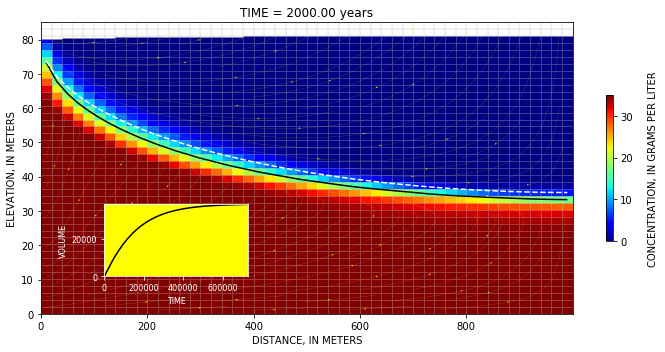

In [15]:
kper = -1
sl = get_sealevel(times0[kper], sl_start, slr_rate)
asoln = lens_analytical(gwf.modelgrid.xcellcenters[0], times0[kper], lx, porosity, 
                        hydraulic_conductivity, recharge, 1000, 1024.5)
ax = make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
            sl, times0[kper], top0, 
            asoln=asoln,
            ax2dict={'xdata': lensvolts0[:kper, 0], 
                     'ydata': lensvolts0[:kper, 1],
                     'xlabel': 'TIME',
                     'ylabel': 'VOLUME',
                     'xlim': (0, lensvolts0[:, 0].max()),
                     'ylim': (0, lensvolts0[:, 1].max())},
            streamplot=True)

# SLR

In [16]:
nper = 100
sl_start = 80.
slr_rate = 1 / (365. * 100.) # 1 meter per 100 years (converted to per day)
time_end = 365. * 100.  # hundred years

etrate = 1.e-3
etdepth = 3.
etsurface = head0[-1, 0, 0, :] + etdepth

hstrt = head0[-1]
cstrt = conc0[-1]

In [17]:
ws = 'temp/pxx_gwt_slr-island'
name = 'slr'
sim = get_model(ws, name, nlay, nrow, ncol, lx,
                top0, sl_start, slr_rate, time_end, 
                hydraulic_conductivity, specific_storage, porosity, 
                recharge,
                alpha_l, alpha_t,
                cfresh, csalt,
                hstrt=hstrt, cstrt=cstrt,
                constant_concentration=False,
                etrate=etrate, etsurface=etsurface, etdepth=etdepth,
                verbosity_level=1, nper=nper)
sim.write_simulation()
v = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package slr.gwfgwt...
  writing model gwf_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-left...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 41 based on size of stress_period_data
    writing package rcha...
    writing package evta...
    writing package oc...
  writing model gwt_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6beta
                                   MODFLOW 6
                U

In [18]:
# load results
head, conc, spdis, times = get_results(ws, sim)
gwf = sim.get_model('gwf_slr')
lensvolts = lens_volume_timeseries(gwf, head, conc, times)
lensvoltsdiff = np.empty(lensvolts.shape, dtype=np.float)
lensvoltsdiff[:, 0] = lensvolts[:, 0]
lensvoltsdiff[:, 1] = lensvolts[:, 1] - lensvolts0[-1, 1]

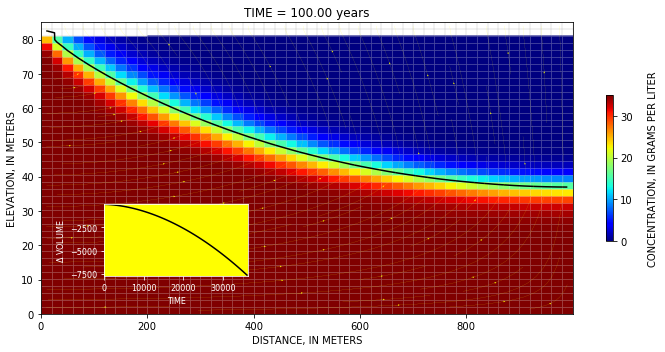

In [19]:
kper = -1
sl = get_sealevel(times[kper], sl_start, slr_rate)
make_figure(gwf, head[kper], conc[kper], spdis[kper], 
            sl, times[kper], top0, 
            ax2dict={'xdata': lensvoltsdiff[:kper, 0], 
                     'ydata': lensvoltsdiff[:kper, 1],
                     'xlabel': 'TIME',
                     'ylabel': '$\Delta$ VOLUME',
                     'xlim': (0, lensvolts[:, 0].max()),
                     'ylim': (lensvoltsdiff[:, 1].min(), lensvoltsdiff[:, 1].max())},
            streamplot=True)